<br>
<font size='12px'>
AdaBoost Example
</font>
<br>

[©2020 AI在弦上](https://www.dataml.cn)

# 概要

1. AdaBoost 基本思想
   - 3个臭皮匠定个诸葛亮
   - 2分类问题, 通过调整训练数据的权重, 学习多个弱分类器, 最终将多个分类器进行线性组合, 提高分类性能
   - 从additive model 的角度看
       - 损失函数, 采用指数形式的损失函数 $L(y, f(x)) = \exp(-yf(x))$
       - 前向分布算法, 加模型本身而言, 各基模型并无先后顺序, 但求解复杂度高. 通过前向分布算法求解, 不一定是最优解, 但降低了求解难度
   
2. AdaBoost 实现步骤
   1. 初始化权重
   2. 确定当前权重下, 最佳基模型
     - 遍历不同切分点, 计算权重样本下的误差, 最初最佳切分点, 识别预测错误样本
     - 计算线性加模型的系数
     - 计算更新权重, 错误样本的权重增加, 正确样本的权重减小
   3. 最终模型的线性组合

## 时间成本
- 阅读 10 分钟
- 实践 30 分钟

## 参考

1. 统计学习方法, 李航, 第8章 提升方法, p137


# 目标

我们的目标通过构造过多个弱分类器(决策树桩)， 就能对训练数据完全分类

弱分类器的基本形式, 其中$c$是待确定参数
$$
\begin{equation}
g(x, c) = \left\{
\begin{aligned}
1, & x < c\\
-1, & x > c
\end{aligned}
\right.
\end{equation}
$$

最终模型的基本形式

$$
G(x) = \displaystyle sign(\sum_{m=1}^M{\alpha_m g_m(x, c_m)})
$$

# 环境

In [1]:
import numpy as np

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

# 实现

## 数据

| 序号 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| x | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| y | 1 | 1 | 1 | -1 | -1 | -1 | 1 | 1 | 1 | -1 |

In [3]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

## 方法

### 基模型

这里使用2叉树作为基模型, 其一般形式, 定义如下

In [4]:
def decision_stump(x, c, l=1):
    
    """
    默认, 左侧节点为+1, 右侧节点为-1
    
    Parameters
    ==========
    x, 输入
    c, 树桩切分点
    l, 左侧节点样本类型
       +1: 正样本
       -1: 负样本
       
    Return
    ======
    分类结果
    
    """
 
    return l * np.sign(c - x)

In [5]:
decision_stump(x, 0.5)

array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

### 切分点

In [6]:
def gen_cut_points(x):
        
    """
    生成切分点
    
    Parameters
    ==========
    x, 训练样本输入
       
    Return
    ======
    相邻输入样本的中间点列表
    
    """
    
    points = np.unique(x)
    return (points[:-1] + points[1:]) / 2

In [7]:
gen_cut_points(x)

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])

### 加权误差函数

In [8]:
def calc_error(x, y, weights, m):
    
    """
    计算加权数据集错误率
    
    Parameters
    ==========
    x, 训练样本输入
    y, 训练样本标签
    weights, 样本的权重
    m, 2分类基模型
    
    Return
    ======    
    error, 加权数据集上的错误率
    error_points, 判别结果, 1: 分类正确, -1: 分类错误
    
    """
    
    predict = m(x)
    error_points = predict * y
    error_points_modify = -np.clip(predict * y, -1, 0)
    
    error = np.dot(error_points_modify, weights)
    return error, error_points

### 初始化样本权重

In [9]:
def init_weights(x):
    n = len(x)
    return  np.full(n, 1/n)

In [10]:
weights = init_weights(x)
c = 2.5
calc_error(x, y, weights, lambda x: decision_stump(x, c))

(0.30000000000000004,
 array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.]))

### 最小误差树桩

In [11]:
def find_decision_stump(x, y, weights=None, cut_points=None):
    
    """
    加权样本集上, 寻找最小误差率对应的树桩, 即对应的切分点及左侧分支的正负样本类型
    
    Parameters
    ==========
    x, 训练样本输入
    y, 训练样本标签
    weights, 样本的权重
    cut_points, 2分类基模型
    
    Return
    ======    
    error, 加权数据集上的错误率
    error_points, 判别结果, 1: 分类正确, -1: 分类错误
    
    """
        
    cut_points = gen_cut_points(x) if cut_points is None else cut_points
    weights = init_weights(x) if weights is None else weights
    
    left_cls = [1, -1]
    cut_points_cls = np.transpose([np.tile(cut_points, len(left_cls)), np.repeat(left_cls, len(cut_points))])
    
    error_info = [calc_error(x, y, weights, lambda x: decision_stump(x, c[0], c[1])) for c in cut_points_cls]
    errors = np.array([e[0] for e in error_info])
    error_points_array = np.array([e[1] for e in error_info])
    
    min_index = np.argmin(errors)
    error, error_points, cut_point_sign = errors[min_index], error_points_array[min_index], cut_points_cls[min_index]
    cut_point, left = cut_point_sign
    
    return cut_point, left, error, error_points, lambda x: decision_stump(x, cut_point, l=left)

In [12]:
cut_point, left, error, error_points, m = find_decision_stump(x, y)
cut_point, left, error, error_points, m

(2.5,
 1.0,
 0.30000000000000004,
 array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.]),
 <function __main__.find_decision_stump.<locals>.<lambda>>)

### 组合模型权重系数计算

In [13]:
def calc_alpha(error):
    return (1/2) * np.log((1 - error) / error)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['WenQuanYi Micro Hei Mono'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


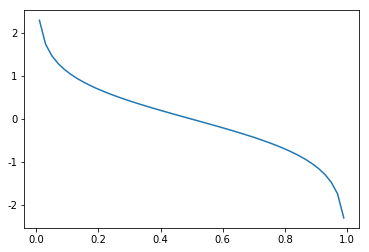

In [14]:
errors = np.linspace(0.01, 0.99, num=50)
alphas = calc_alpha(errors)
plt.plot(errors, alphas)

### 权重系数更新

In [15]:
def update_weight(weights, error, error_points, alpha=None):
    alpha = alpha or calc_alpha(error) 
    adjust_ratio = np.exp(-alpha * error_points)
    z = np.dot(weights, adjust_ratio)
    return (weights * adjust_ratio) / z


In [16]:
update_weight(weights, error, error_points)

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.16666667, 0.16666667, 0.16666667, 0.07142857])

### 模型融合

In [17]:
def gen_additive_model(alphas, models):
    return lambda x: np.sign(np.dot(alphas, [m(x) for m in models]))

### 训练模型

In [18]:
def adaboost(x, y, M=10, max_error=0):
    raw_weights = init_weights(x)
    weights = init_weights(x)
    cut_points = gen_cut_points(x)
    alphas = list()
    models = list()
    for m in range(M):
        cut_point, left, error, error_points,  weak_clf = find_decision_stump(x, y, weights=weights, cut_points=cut_points)
        alpha = calc_alpha(error)
        alphas.append(alpha)
        models.append(weak_clf)
        model = gen_additive_model(alphas, models)
        additive_error, _ = calc_error(x, y, raw_weights, model)
        weights = update_weight(weights, error, error_points)
        print('\niterator: ', m + 1)
        print('additive error:', additive_error)  
        print('cut point: ', cut_point)
        print('left cls: ', left)
        print('error points: ', error_points)
        print('alpha:', alpha)  
        print('update weights:', weights)
        if additive_error <= max_error:
            print('find the target model')
            break
    return model


In [19]:
model = adaboost(x, y)


iterator:  1
additive error: 0.30000000000000004
cut point:  2.5
left cls:  1.0
error points:  [ 1.  1.  1.  1.  1.  1. -1. -1. -1.  1.]
alpha: 0.4236489301936017
update weights: [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]

iterator:  2
additive error: 0.30000000000000004
cut point:  8.5
left cls:  1.0
error points:  [ 1.  1.  1. -1. -1. -1.  1.  1.  1.  1.]
alpha: 0.6496414920651301
update weights: [0.04545455 0.04545455 0.04545455 0.16666667 0.16666667 0.16666667
 0.10606061 0.10606061 0.10606061 0.04545455]

iterator:  3
additive error: 0.0
cut point:  5.5
left cls:  -1.0
error points:  [-1. -1. -1.  1.  1.  1.  1.  1.  1. -1.]
alpha: 0.7520386983881369
update weights: [0.125      0.125      0.125      0.10185185 0.10185185 0.10185185
 0.06481481 0.06481481 0.06481481 0.125     ]
find the target model
